In [53]:
import pickle
import warnings
import random
import umap
import torch

import networkx as nx
import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict
from scipy.spatial import distance, KDTree
from scipy import stats
from sklearn import decomposition
from IPython.display import display, Markdown
from itertools import product, combinations

from torch.nn import functional as F

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 500

In [4]:
embeds, rows = [], []

titles = set()

for path in tqdm(glob('../data/clean-embeds/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            
            title = ' '.join(line.pop('tokens'))
            
            if title not in titles:
                embeds.append(line.pop('embedding'))
                rows.append(OrderedDict(title=title, **line))
                titles.add(title)

100%|██████████| 66/66 [00:26<00:00,  2.53it/s]


In [5]:
embeds = np.stack(embeds)

In [6]:
df = pd.DataFrame(rows)

In [12]:
domains = df.label.unique()

In [13]:
domains

array(['dailycaller.com', 'bloomberg.com', 'thehill.com',
       'huffingtonpost.com', 'dailykos.com', 'nytimes.com', 'cnn.com',
       'wsj.com', 'apnews.com', 'breitbart.com', 'foxnews.com',
       'washingtonpost.com', 'buzzfeed.com'], dtype=object)

In [8]:
embeds.shape

(642151, 512)

In [33]:
def mass_dist(domain):
    
    ddf = df[df.label==domain]
    
    masses = {
        d: ddf[f'p_{d}'].sum()
        for d in domains if d != domain
    }
    
    total = sum(masses.values())
    masses_norm = {d: m / total for d, m in masses.items()}
    
    return masses_norm

In [35]:
rows = []
for d1 in tqdm(domains):
    for d2, m in mass_dist(d1).items():
        rows.append((d1, d2, m))

100%|██████████| 13/13 [00:01<00:00,  6.84it/s]


In [38]:
mdf = pd.DataFrame(rows, columns=('d1', 'd2', 'm'))

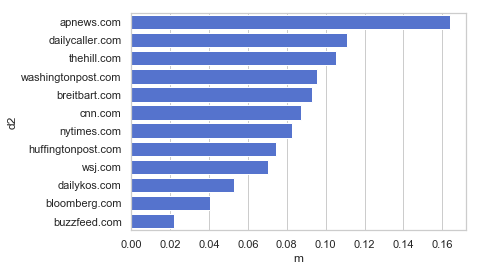

In [75]:
pdf = mdf[mdf.d1=='foxnews.com'].sort_values('m', ascending=False)
sns.barplot(x='m', y='d2', data=pdf, color='RoyalBlue')